In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir("..")

DATA_DIR = os.getenv("DATA_DIR")
OUTPUT_DIR = os.getenv("OUTPUT_DIR")

In [2]:
from utils.load_data import load_data

label_path = os.path.join(DATA_DIR, "labels/labels.csv")
embedding_path = os.path.join(OUTPUT_DIR, "gigapath_slide_embeds_cls.pkl")
fold_path = os.path.join(DATA_DIR, "folds.json")

df = load_data(
    label_path=label_path, embedding_path=embedding_path, fold_path=fold_path
)

In [3]:
# map specimen id to a list of WSIs
specs = df.groupby("specimen_id").groups
specs = {k: list(v) for k, v in specs.items()}

# get list of slides within each fold
slide_folds = df.groupby("fold").groups
slide_folds = [list(slides) for slides in slide_folds.values()]

In [4]:
from utils.Label import Label

specimen_df = df.reset_index()[
    ["specimen_id", "bowens", "scc", "bcc", "na"]
].drop_duplicates(subset=["specimen_id"])

spec_freqs = {
    label: specimen_df[label].value_counts(normalize=True).iloc[1]
    for label in Label._member_names_
}

In [5]:
X = df["embedding"]
y = df["label"]

In [6]:
from typing import List, Tuple

import pandas as pd
import numpy as np


def train_val_split(
    X: pd.DataFrame, y: pd.DataFrame, val_fold_indices: List[str]
) -> Tuple[List[np.ndarray], List[int], List[np.ndarray], List[int]]:
    """
    Construct training and validation sets from the provided data using
    the given indices for the validation set.

    Parameters
    ----------
    X : pd.DataFrame
        The feature set

    y : pd.DataFrame
        The targets

    val_fold_indices : List[str]
        The indices of samples to include in the validation set

    Returns
    -------
    Tuple[List[np.ndarray], List[int], List[np.ndarray], List[int]]
        X_train, y_train, X_val, y_val
    """
    X_val = X.loc[val_fold_indices]
    X_train = X[X.index.difference(X_val.index)]

    y_val = y.loc[val_fold_indices]
    y_train = y[y.index.difference(y_val.index)]

    assert X_train.index == y_train.index
    assert X_val.index == y_val.index

    return (
        X_train.to_list(),
        y_train.to_list(),
        X_val.to_list(),
        y_val.to_list(),
    )

In [7]:
def get_spec_level_probs(
    slide_indices: List[str], probs: np.ndarray
) -> Tuple[List[str], np.ndarray]:
    """
    Calculates the average model output probabilities for each class
    at the specimen level rather than slide level.

    Parameters
    ----------
    slide_indices : List[str]
        A list of slide ids for which the specimen is the first 6 chars

    probs : np.ndarray
        Classifier output probabilities for each slide included in
        slide_indices; shape (N, O) where N is the number of slides
        and O is the number of classes

    Returns
    -------
    List[str]
        The specimen ids

    np.ndarray
        The average probabilities for each specimen; shape (M, O) where
        M is the number of specimens and O is the number of classes
    """
    combined_probs = {}
    for j, slide_idx in enumerate(slide_indices):
        spec = slide_idx[:6]
        if combined_probs.get(spec) is None:
            combined_probs[spec] = [probs[j]]
        else:
            combined_probs[spec].append(probs[j])

    for k in combined_probs.keys():
        combined_probs[k] = np.array(combined_probs[k])
        combined_probs[k] = (
            combined_probs[k].sum(axis=0) / combined_probs[k].shape[0]
        )

    return list(combined_probs.keys()), np.array(list(combined_probs.values()))

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, auc

%matplotlib inline


def plot_eval(
    mean_x: np.ndarray,
    onehot_labels: np.ndarray,
    probs: np.ndarray,
    ax: plt.Axes,
    type: str,
    fold_idx: int,
    plot_chance_level: bool,
):
    # set eval type specific vars
    if type == "ROC":
        curve_display = RocCurveDisplay
        set_initial_interp_value = True
        interp_transform = lambda x: x
        x_attr = "fpr"
        y_attr = "tpr"
        auc_attr = "roc_auc"
    else:
        curve_display = PrecisionRecallDisplay
        set_initial_interp_value = False
        interp_transform = lambda x: np.flip(x)
        x_attr = "recall"
        y_attr = "precision"
        auc_attr = "average_precision"

    # create the curve
    curve = curve_display.from_predictions(
        onehot_labels,
        probs,
        name=f"{type} fold {fold_idx}",
        plot_chance_level=plot_chance_level,
        ax=ax,
        alpha=0.3,
        lw=1,
    )

    # interpolate results using mean_x param to allow for averaging of curves
    interp_y = np.interp(
        mean_x,
        interp_transform(getattr(curve, x_attr)),
        interp_transform(getattr(curve, y_attr)),
    )
    interp_y[0] = 0.0 if set_initial_interp_value else interp_y[0]

    return interp_y, getattr(curve, auc_attr)


def create_mean_curve(
    mean_x: np.ndarray,
    cv_y: np.ndarray,
    aucs: np.ndarray,
    ax: plt.Axes,
    type: str,
    class_name: str,
):
    if type == "ROC":
        set_final_mean_value = True
        ax.set(
            xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title=f"Mean ROC curve with variability for {class_name}",
        )
    else:
        set_final_mean_value = False
        ax.set(
            xlabel="Recall",
            ylabel="Precision",
            title=f"Mean precision-recall curve with variability for {class_name}",
        )

    # prep plot data
    mean_y = np.mean(cv_y, axis=0)
    mean_y[-1] = 1.0 if set_final_mean_value else mean_y[-1]
    mean_auc = auc(mean_x, mean_y)
    std_auc = np.std(aucs)
    auc_label = "AUC" if type == "ROC" else "AP"

    # plot the mean line
    ax.plot(
        mean_x,
        mean_y,
        color="b",
        label=r"Mean %s (%s = %0.2f $\pm$ %0.2f)"
        % (type, auc_label, mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # plot the standard deviation bands
    std_y = np.std(cv_y, axis=0)
    y_upper = np.minimum(mean_y + std_y, 1)
    y_lower = np.maximum(mean_y - std_y, 0)
    ax.fill_between(
        mean_x,
        y_lower,
        y_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.legend(loc="lower right")

In [9]:
def crossval(clf, folds: list, y_onehot: pd.DataFrame):
    # dictionaries to keep eval curve results for each label
    tprs = {label: [] for label in Label._member_names_}
    aucs = {label: [] for label in Label._member_names_}
    precisions = {label: [] for label in Label._member_names_}
    aps = {label: [] for label in Label._member_names_}

    # mean x vals and axes for curves
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)
    roc_fig, roc_axs = plt.subplots(2, 2, figsize=(12, 12))
    prc_fig, prc_axs = plt.subplots(2, 2, figsize=(12, 12))

    for i, val_fold_indices in enumerate(folds):
        # fit the classifier on the train data and extract probs
        X_train, y_train, X_val, _ = train_val_split(X, y, val_fold_indices)
        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_val)

        # probs are on slide-level - need specimen level
        _, probs = get_spec_level_probs(val_fold_indices, probs)

        # get onehot labels for val set
        y_onehot_val = y_onehot.loc[val_fold_indices].drop_duplicates(
            subset=["specimen_id"]
        )

        # for each predicted class, plot the current classifier's eval
        # and retain relevant data in dicts
        for j, class_of_interest in enumerate(Label._member_names_):
            interp_tpr, roc_auc = plot_eval(
                mean_x=mean_fpr,
                onehot_labels=y_onehot_val[f"{class_of_interest}"],
                probs=probs[:, Label[class_of_interest].value],
                ax=roc_axs[j // 2][j % 2],
                type="ROC",
                fold_idx=i,
                plot_chance_level=i == len(folds) - 1,
            )
            tprs[class_of_interest].append(interp_tpr)
            aucs[class_of_interest].append(roc_auc)

            interp_precision, average_precision = plot_eval(
                mean_x=mean_recall,
                onehot_labels=y_onehot_val[f"{class_of_interest}"],
                probs=probs[:, Label[class_of_interest].value],
                ax=prc_axs[j // 2][j % 2],
                type="PRC",
                fold_idx=i,
                plot_chance_level=False,
            )
            precisions[class_of_interest].append(interp_precision)
            aps[class_of_interest].append(average_precision)

    # plot the mean eval curves
    for j, class_of_interest in enumerate(Label._member_names_):
        create_mean_curve(
            mean_fpr,
            tprs[class_of_interest],
            aucs[class_of_interest],
            roc_axs[j // 2][j % 2],
            "ROC",
            class_of_interest,
        )

        prc_ax = prc_axs[j // 2][j % 2]
        create_mean_curve(
            mean_recall,
            precisions[class_of_interest],
            aps[class_of_interest],
            prc_ax,
            "PRC",
            class_of_interest,
        )

        # add chance line for PRC == label freq at specimen level
        prc_ax.axhline(
            spec_freqs[class_of_interest],
            linestyle="--",
            label=r"Chance level (AP = %0.2f)"
            % (spec_freqs[class_of_interest]),
            color="black",
        )

        # reorder legend
        handles, labs = prc_ax.get_legend_handles_labels()
        handles[-1], handles[-3] = handles[-3], handles[-1]
        labs[-1], labs[-3] = labs[-3], labs[-1]
        prc_ax.legend(handles=handles, labels=labs, loc="lower right")

    roc_fig.show()
    prc_fig.show()

In [10]:
y_onehot = df[["bowens", "scc", "bcc", "na", "specimen_id"]]

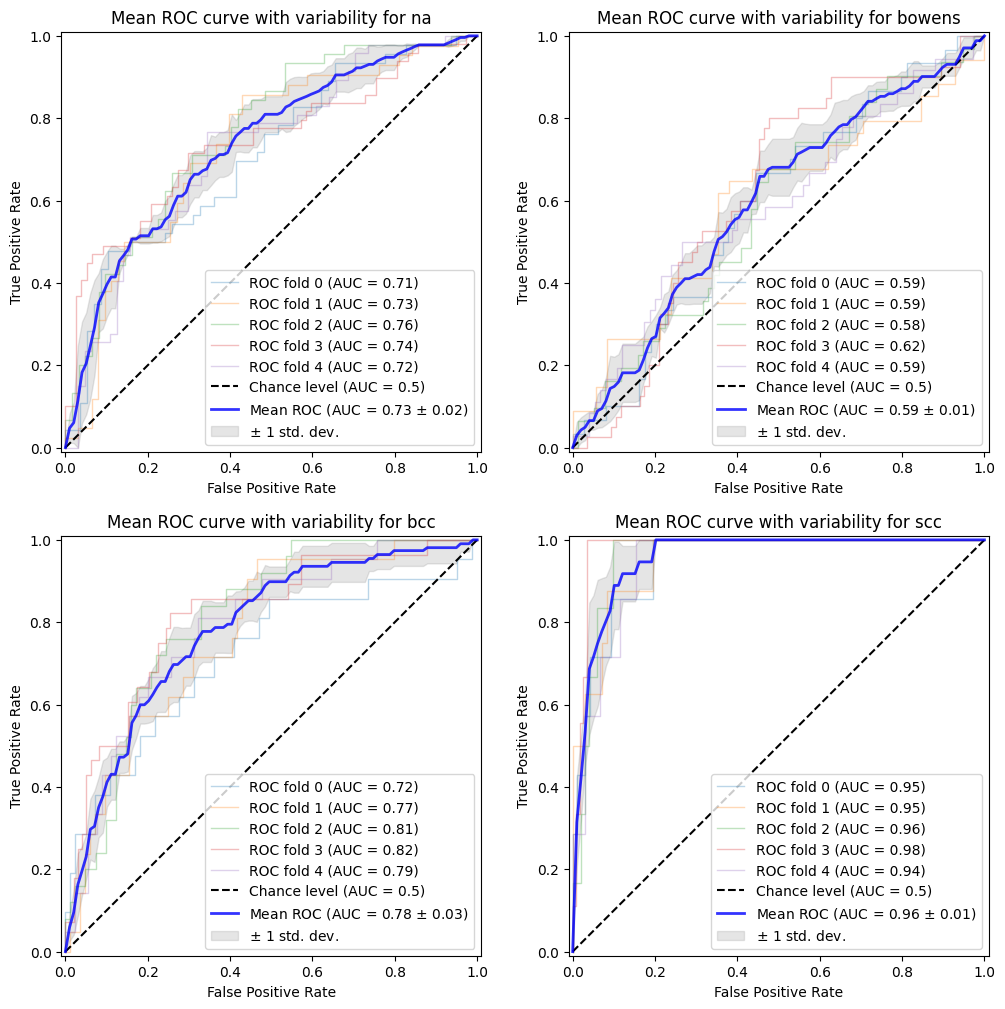

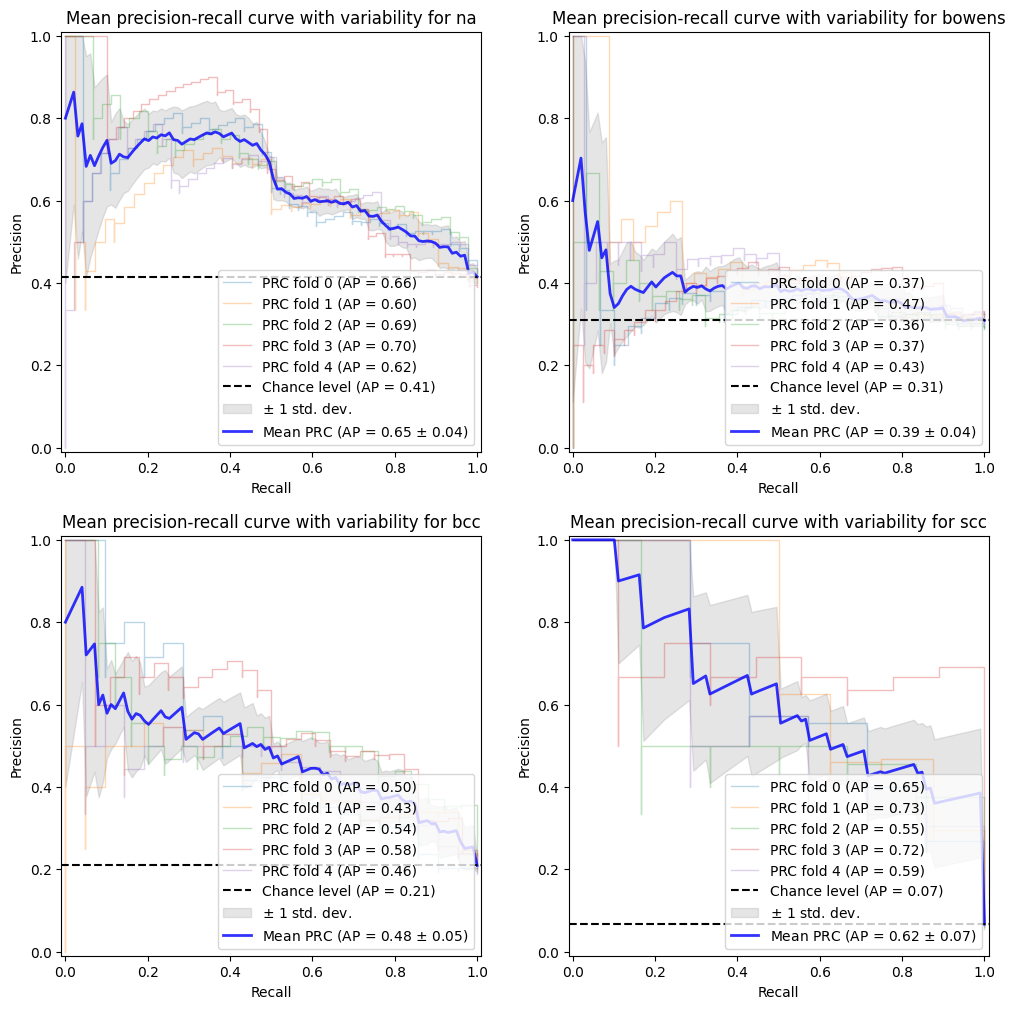

In [11]:
from xgboost import XGBClassifier

clf = XGBClassifier(objective="multi:softmax", num_class=4)
crossval(clf, slide_folds, y_onehot)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=500, solver="saga")
crossval(clf, slide_folds, y_onehot)

In [ ]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="log_loss")

crossval(clf, slide_folds, y_onehot)